In [2]:
 
import numpy as np
import matplotlib
from neo.io import AxonIO
#import seaborn as sns
import matplotlib.pyplot as plt
# import the data
#flydir = '/Volumes/hm_data/MN optogenetic activation/b1/1218 fly 3/'
from scipy import stats
from scipy import signal

In [3]:
flydir = '/home/alysha/media/imager/FlyDataD/untitled folder/recent_muscle_reocrdings_thru_12_13_18/'
#lysh_ephy_data_07_03/'
#lysh_ephys_ata_old/

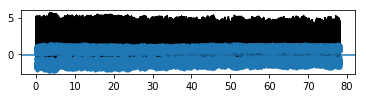

In [4]:
#flydir = '/home/alysha/media/imager/FlyDataD/lysh_ephys_ata_old/'
#flydir = '/home/alysha/media/imager/FlyDataD/brad_b2_data/'

#localfile = flydir + '2018_03_05_0024.abf'
#localfile = flydir + '2018_10_29_0009.abf'
localfile = flydir + '2018_12_06_0005.abf'
 
r =AxonIO(localfile)
 
bl = r.read_block(lazy=False, cascade=True)
 
hutch = np.asarray(bl.segments[0].analogsignals[5])
 
fs_axon = 1.0/20000.0
 
times=np.linspace(0,len(hutch)/(1/fs_axon),len(hutch))
 
# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)
 
ax1 = plt.subplot(311)
 
ax1.plot(times,hutch_det,'k')
 
#identify all relative minima
from scipy.signal import argrelmin
inds = argrelmin(hutch_det, order = 5)
ax1.plot(times[inds], hutch_det[inds], '.')
ax1.axhline(-0.08)
inds = np.array(inds)
inds = np.transpose(inds)
 

In [5]:
 
## identify the ventral flip of each wingbeat by applying a threshold
thresh = -.01 #adjust as needed
flipInds = []
flipInds = np.argwhere(hutch_det[inds]>thresh)
flipInds = inds[flipInds]
flipInds = flipInds[:,0]
 
#% now find the phase of the ventral flip 
 
#filter hütchen signal to make it more sinusoidal
 
from scipy import signal
from scipy.signal import butter, lfilter, freqz
 
def butter_lowpass(highcut, fs, order=4):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 

/home/alysha/.local/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


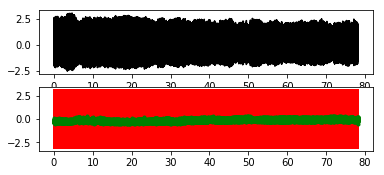

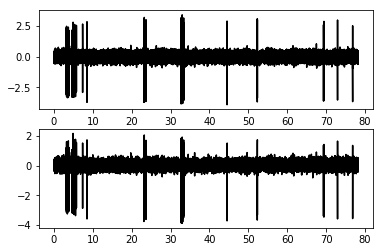

In [6]:
 
# Filter requirements.
order = 4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 300.0  # desired cutoff frequency of the filter, Hz
 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(highcut, fs, order)
 
 
hutch_filt = signal.filtfilt(b, a, hutch_det)
 
ax2 = plt.subplot(312, sharex=ax1)
 
ax2.plot(times,hutch_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
hutch_analytic = hilbert(hutch_filt)
inst_phase = np.angle(hutch_analytic)
 
 
ax3 = plt.subplot(313, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,hutch_analytic,'k')
ax3.plot(times,inst_phase,'r')
ax3.plot(times[flipInds],inst_phase[flipInds],'g.')


#%% detect muscle spikes and sort them
 
musc = np.asarray(bl.segments[0].analogsignals[0])
 
plt.figure(2)
ax1 = plt.subplot(211)
ax1.plot(times,musc,'k')
 
#apply median filter and detrend muscle signal
 
musc_det = musc-signal.medfilt(musc,35)
 
ax2 = plt.subplot(212, sharex = ax1)
ax2.plot(times,musc_det,'k')
 
# threshold the detrended signal (convert the spikes into binary)
# calculate the change in, identify the spike starts/stops 
#thresh = 4
thresh =  0.6 #1.1
deltas = np.diff(np.array(-1*musc_det>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]

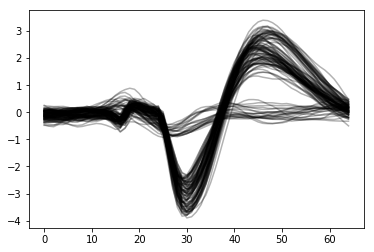

In [7]:
  
#find the peak changes in the thresholded signal, and find the associated waveform   
intervals = np.hstack((starts,stops))
spiketimes = [np.argmax(musc[sta:stp])+sta for sta,stp in intervals][2:-2]
waveforms = [musc[pk-25:pk+40] for pk in spiketimes]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(waveforms)):
    plt.plot(waveforms[i], 'k', alpha = 0.3)
 
wv_mtrx = np.vstack([np.array(wv) for wv in waveforms])

 
#%% extract the features of the waveforms to cluster the data
 
cov_wav = np.cov(wv_mtrx.T)
eig_vals, eig_vecs = np.linalg.eig(cov_wav)
#for ev in eig_vecs:
    #np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

[[ 0.59790463  0.30579599]
 [10.92433136 -0.15926857]]


' \ntest3 = np.argwhere(labels=0)\n\nfor i in range(len(test3)):\n   plt.plot(wv_mtrx[test3[i]])\n'

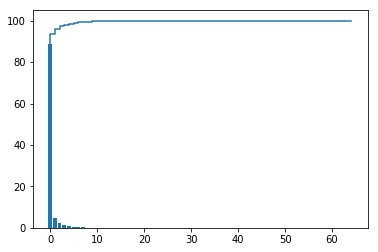

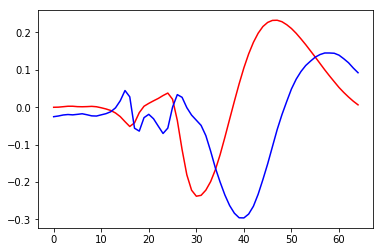

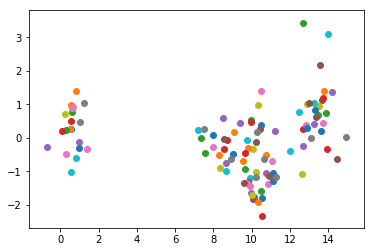

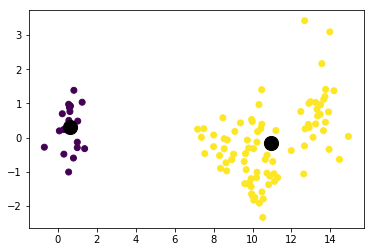

In [8]:
 
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
 
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
 
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
 
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
 
plt.figure(4)
plt.bar(range(65), var_exp)
plt.step(range(65), cum_var_exp)
 
#contruct the projection matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(65,1),
                      eig_pairs[1][1].reshape(65,1)))
 
plt.figure(5)
plt.plot(matrix_w[:,0],'r')
plt.plot(matrix_w[:,1],'b')
 
plt.figure(6)
proj = []
proj1 = []
proj2 =[]
for i in range(len(wv_mtrx)):
    musc_proj = np.dot(wv_mtrx[i], matrix_w)
    proj.append(musc_proj[0])
    proj1.append(musc_proj[1])
    proj2.append(musc_proj)
    plt.scatter(musc_proj[0], musc_proj[1])
 
     
X = np.array(list(zip(proj, proj1)))
 
#%%
from sklearn.cluster import KMeans
 
# Number of clusters
#kmeans = KMeans(n_clusters=2)
#n_clusters=1
n_clusters=2
kmeans = KMeans(n_clusters=2)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
 
#print(C) 
print(centroids)
 
plt.figure(7)
plt.scatter(X[:, 0], X[:, 1], c=labels)
 
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200);
 
""" 
test3 = np.argwhere(labels=0)
 
for i in range(len(test3)):
    plt.plot(wv_mtrx[test3[i]])
"""

In [14]:
    
#%%


###### categorize and plot the labels 

labeled_spikes= zip(spiketimes,labels)

In [15]:
def cutoff(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

#Type_a_spikes = cutoff(0.5, labeled_spikes)
Type_a_spikes = cutoff(0.5, labeled_spikes)

In [16]:
def cutoff_2(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Type_b_spikes = cutoff_2(0.5, labeled_spikes)

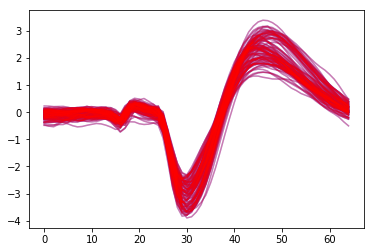

In [17]:
#print(zip_hutch)
#
x_val = [x[0] for x in Type_a_spikes]
y_val = [x[1] for x in Type_a_spikes]

Type_b_spikes = Type_a_spikes

x_val_b = [x[0] for x in Type_b_spikes]
y_val_b = [x[1] for x in Type_b_spikes]



labeled_waveforms_type_a = [musc[pk-25:pk+40] for pk in x_val]

labeled_waveforms_type_b = [musc[pk-25:pk+40] for pk in x_val_b]
 
#plot the collected waveforms
plt.figure(3)
for i in range(len(labeled_waveforms_type_a)):
    plt.plot(labeled_waveforms_type_a[i], 'b', alpha = 0.3)

plt.figure(3)
for i in range(len(labeled_waveforms_type_b)):
    plt.plot(labeled_waveforms_type_b[i], 'r', alpha = 0.3)

#%%
### delete this freq shit
###Use Hilbert function againt o calculate the instantaneous freq. of B2

plt.figure(12)

# Filter requirements.
order = 10  #4
fs = 20000.0       # sample rate, Hz
lowcut = 100
highcut = 200.0  # desired cutoff frequency of the filter, Hz

Brad, the chrimson signal was moved to channel 12 for your recordings/the more recent ones!

Use the commented out bit below:
#crimson = np.asarray(bl.segments[0].analogsignals[12])

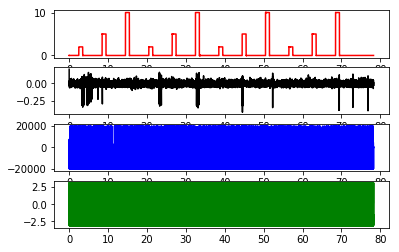

In [18]:
crimson = np.asarray(bl.segments[0].analogsignals[12])
#crimson = np.asarray(bl.segments[0].analogsignals[7])

def butter_lowpass_1(highcut, fs, order=10):
    nyq = 0.5 * fs
    #low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='low', analog=False)
    return b, a
 
 

 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass_1(highcut, fs, order)
 
 
muscb2_filt = signal.filtfilt(b, a, musc_det)

ax1 = plt.subplot(411)
ax1.plot(times, crimson, 'r')
 
ax2 = plt.subplot(412, sharex=ax1)
 
ax2.plot(times,muscb2_filt,'k')
 
# perform a Hilbert transformation on the filtered signal to calculate instantaneous phase, amplitude, etc.
from scipy.signal import hilbert
 
musc_analytic = hilbert(muscb2_filt)
inst_phase = np.angle(musc_analytic)

#instantaneous_phase = np.unwrap(np.angle(musc_analytic))
instantaneous_frequency = (np.diff(inst_phase) /(2.0*np.pi) * fs)
 
ax3 = plt.subplot(413, sharex=ax1)
 
# plot the identified ventral flip on the phase data
ax3.plot(times,musc_analytic,'k')
#ax3.plot(times,inst_phase,'r')

times_freq = np.delete(times, 1540096)

ax3.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(times, inst_phase, 'g')

In [66]:
#ax1 = plt.subplot(611)

#ax1.plot(times_freq, instantaneous_frequency, 'b')
#ax3.plot(times[flipInds],inst_phase[flipInds],'g.')

IndexError: list index out of range

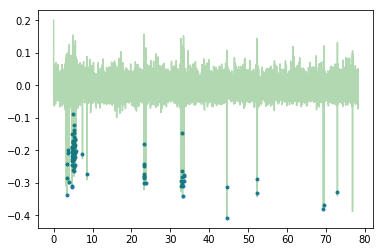

In [19]:
#%%



### delete this freq shit also 
import numpy as np
#data = musc[x_val]
data = musc[x_val_b]
#data = muscb2_filt
import seaborn as sns
data1 = muscb2_filt[x_val_b]
#data1 = muscb2_filt[x_val]
from scipy.signal import savgol_filter

#detect B2 spikes-- Use negative values

#times_between_spikes =  

plt.figure(13)

labeled_b2_spikes= zip(times[x_val_b], muscb2_filt[x_val_b])
ax1 = plt.subplot(111)
#inds_b2 = argrelmin(muscb2_filt[x_val_b], order = 5)
#ax1.plot(times[inds_b2], muscb2_filt[inds_b2], '.')
ax1.plot(times[x_val_b], muscb2_filt[x_val_b], '.')
ax1.plot(times, muscb2_filt, 'g', alpha = 0.3)

def cutoff_3(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

Detected_spikes = cutoff_3(0.2, labeled_b2_spikes)

times_k= []
periods = []

for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)


In [18]:
'''
times_k= []
periods = []



for i in range(len(times)):
    for t in range(len(x_val_b)):
        #z = times[x_val_b[t-2]]
        a = times[x_val_b[t]]
        b = times[x_val_b[t-1]]
        c = times[x_val_b[t+1]]
        #d = times[x_val_b[t+2]]
        if t<= 2:
            periods.append(100)
        else:
            times_k.append(times[x_val_b[t]])
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
            #if 
              #  periods.append(a-b)
'''

'\ntimes_k= []\nperiods = []\n\n\n\nfor i in range(len(times)):\n    for t in range(len(x_val_b)):\n        #z = times[x_val_b[t-2]]\n        a = times[x_val_b[t]]\n        b = times[x_val_b[t-1]]\n        c = times[x_val_b[t+1]]\n        #d = times[x_val_b[t+2]]\n        if t<= 2:\n            periods.append(100)\n        else:\n            times_k.append(times[x_val_b[t]])\n            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4\n            periods.append(avg)\n            #if \n              #  periods.append(a-b)\n'

In [240]:
spike_window = 3
window = 10

times_p =[]
periods =[]

avg = 100

for i in range(len(times)):
    if i in x_val_b[1:]:
        c = x_val_b.index(i)
        a = times[x_val_b[c]]
        b = times[x_val_b[c-1]]
        #c = times[x_val_b[i+1]]
        #d = times[x_val_b[t+2]]
        if c<= 1:
            periods.append(100)
        else:
            times_p.append(times[x_val_b[c]])
            #print ('spike')
            avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            periods.append(avg)
    else:
        periods.append(avg)
        


In [20]:
spike_window = 3
window = 10

times_p =[]
periods =[]

avg = 300

gaussian_window = 1000

gaussian_spike_count = []

times_inds = np.arange(len(times))

for i in times_inds[::50]:
    spike_count = 0
    for j in range((gaussian_window)):
        j= j-500
        if i+j in x_val_b:
            #c = x_val_b.index(i)
            #spike_count = 0
            spike_count = spike_count + 1
            #c = times[x_val_b[i+1]]
            #d = times[x_val_b[t+2]]
            #if c<= 1:
            #    periods.append(100)
            #else:
            #    times_p.append(times[x_val_b[c]])
            #    #print ('spike')
            #    avg= ((a-b))#+(c-a))/2 #+(d-c))/3 #+(b-z))/4
            #    periods.append(avg)
    if spike_count > 0:
        gaussian_spike_count.append(spike_count)
    else: 
        gaussian_spike_count.append(spike_count)
        


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (31294,) and (3827,)

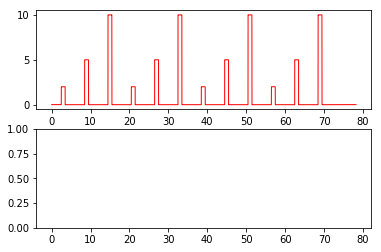

In [21]:

plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times[::50], crimson[::50], 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
#ax2.set_ylim(-5, 20)
#savitzky_golay
freq_hat = savgol_filter(gaussian_spike_count, 51, 7) # window size 51, polynomial order 3

#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)

#ax2.plot(times, freq_hat[:-3],'k', linewidth = 0.75)
ax2.plot(times[::50], freq_hat,'k', linewidth = 0.75)

#peristimulus time historgram

#and then compute the Fourier transform as


#plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')

ax1.set_ylabel('Crimson Stimulus', size=10)
ax1.set_title(r'$\mathrm{Time\ Course\ of\ Crimson\ Modulated\ B2\ Muscle\ Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of B2 Firing', size=10)
plt.xlabel('Power Muscle Activity $\phi$', size=10)

import numpy.fft as fft
spectrum = fft.fft(data1)
#You can then plot the magnitudes of the FFT as

In [ ]:
savgol_filter

In [299]:
print(len(periods))
print(len(times))


0
1564672


In [242]:
b2_frequencies = [1/period for period in periods]
len (b2_frequencies)

1564672

In [148]:
x = np.linspace(0, 10, 20, endpoint=False)
y = np.cos(-x**2/6.0)
f = signal.resample(y, 100)
xnew = np.linspace(0, 10, 100, endpoint=False)

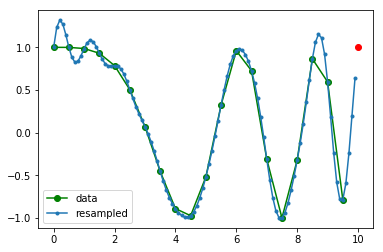

In [149]:
import matplotlib.pyplot as plt
plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [24]:
x= times
y2  = b2_frequencies

f = signal.resample(y2, 180000000)
xnew = np.linspace(0, times[len(y2)-1], 180000000, endpoint=False)

In [295]:
import matplotlib.pyplot as plt
plt.plot(x, y2, 'go-', xnew, f, '.-', 10, y2[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

KeyboardInterrupt: 

In [24]:
import pandas as pd

In [22]:


#power_muscle_frequencies_df = pd.DataFrame((b2_frequencies))
#power_muscle_frequencies_df.to_csv('s104_i1_01_frequencies_df.csv', index=False)

i1_frequencies_df = pd.DataFrame((gaussian_spike_count))
i1_frequencies_df.to_csv('s104_i1_16_frequencies_df.csv', index=False)

i1_frequencies_savgol_df = pd.DataFrame((freq_hat))
i1_frequencies_savgol_df.to_csv('s104_i1_16_frequencies_savgol_df.csv', index=False)


#periods_df = pd.DataFrame((periods))
#periods_df.to_csv('s104_i1_01_periods_df.csv', index=False)



NameError: name 'pd' is not defined

In [25]:
chrimson_df = pd.DataFrame((crimson))
chrimson_df.to_csv('s104_i1_chrimson_16_df.csv', index=False)

In [26]:
times_df = pd.DataFrame(times)
times_df.to_csv('s104_i1_times_16_df.csv', index=False)

NameError: name 'b2_frequencies' is not defined

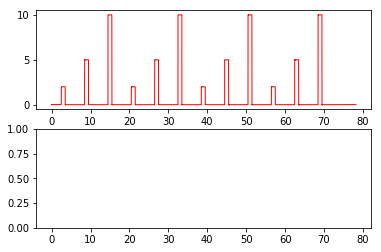

In [27]:

plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
#ax2.set_ylim(-5, 20)
#savitzky_golay
freq_hat = savgol_filter(b2_frequencies, 75, 11) # window size 51, polynomial order 3

#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)

#ax2.plot(times, freq_hat[:-3],'k', linewidth = 0.75)
ax2.plot(times, b2_frequencies,'k', linewidth = 0.75)

#peristimulus time historgram

#and then compute the Fourier transform as


#plt.title(r'$\mathrm{Histogram\ of\ B2 Muscle Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')

ax1.set_ylabel('Crimson Stimulus', size=10)
ax1.set_title(r'$\mathrm{Time\ Course\ of\ Crimson\ Modulated\ B2\ Muscle\ Activity:}\ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of B2 Firing', size=10)
plt.xlabel('Power Muscle Activity $\phi$', size=10)

import numpy.fft as fft
spectrum = fft.fft(data1)
#You can then plot the magnitudes of the FFT as

The last few cells are probably the ones you're after.  So here you can see (vs the other notebook I sent you) the limitations of the direct data period/freq analysis.  This will be ameliorated a bit by increasing the sample size.  However, the other approach I tried before (that I can also try and recreate) was running these raw traces through filters to try get slightly smoother.

In [29]:
f1 = pd.read_csv('s104_i1_16_frequencies_df.csv')
f2 = pd.read_csv('s104_i1_16_frequencies_savgol_df.csv')
f3 = pd.read_csv('s104_i1_chrimson_16_df.csv')
f4 = pd.read_csv('s104_i1_times_16_df.csv')


In [30]:
df = pd.DataFrame()

# Add a new columns with impoact force in units of Newtons
df['b2 frequencies'] = f1
df['b2 frequencies_savgol'] = f2
df['chrimson stimulus'] = f3
df['times'] = f4

# Take a look
df.head()

,chrimson stimulus,times
0,0.009766,0.00000
1,0.010071,0.00005
2,0.009766,0.00010
3,0.009460,0.00015
4,0.009460,0.00020


In [31]:
max_chrimson_stim = df['chrimson stimulus'] >= 9.9
#max_chrimson_stim.head()

max_inds = df.loc[max_chrimson_stim]
max_inds.head()

,chrimson stimulus,times
289284,9.993896,14.464209
289285,9.994812,14.464259
289286,9.996338,14.464309
289287,9.995422,14.464359
289288,9.996033,14.464409


In [58]:
#for ind in range(len(max_inds)-1):
#    if times[ind]-times[ind -1] >= 1:
#        chrimson_on = 

SyntaxError: invalid syntax (<ipython-input-58-9ed1209a9b95>, line 3)

In [32]:
crimson_on = []
crimson_off = []

for f in range(len(f3)-1):
    if crimson[f]-crimson[f-1]>= 1.05:  #1.55
        crimson_on.append(f)
    if crimson[f]-crimson[f+1] >= 1.05:  #<= - 0.75:
        crimson_off.append(f)

In [33]:
for i in range(len(crimson_on)-1): 
    if crimson_on[i] - crimson_on[i+1] >= - 100:
        del crimson_on[i+1]

for i in range(len(crimson_off)-1): 
    if crimson_off[i] - crimson_off[i+1] >= - 100:
        del crimson_off[i+1]        

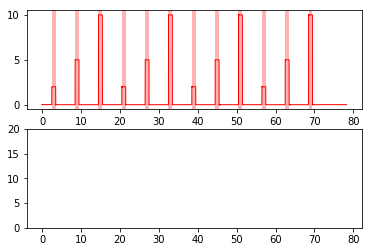

In [34]:
fig =plt.figure(14)

ax1 = plt.subplot(211)
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(0, 20)
#ax2.set_xlim(20, 80)
#savitzky_golay
'''freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'''
#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)
        
for i in range(len(crimson_on)):
    ax1.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)
    #ax2.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)

In [313]:
print(len(crimson_on), (crimson_on)) 
print(len(crimson_off), (crimson_off))

(12, [49281, 169283, 289284, 409282, 529283, 649280, 769280, 889278, 1009279, 1129319, 1249319, 1369317])
(12, [69280, 189280, 309279, 429278, 549280, 669278, 789276, 909276, 1029276, 1149315, 1269315, 1389313])


In [83]:
'''
df_freq_upon_signal = pd.DataFrame()

for i in range(len(crimson_on)):
    on_signal = crimson_on[i]
    f = b2_frequencies[on_signal-5000: on_signal+10000]
    
    f2 = signal.resample(y2, )
    xnew = np.linspace(0, times[len(y2)-1], 180000000, endpoint=False)
    
    
    
    df_freq_upon_signal[i]=f
'''

(1249319, 4.9954224)


TypeError: 'module' object is not callable

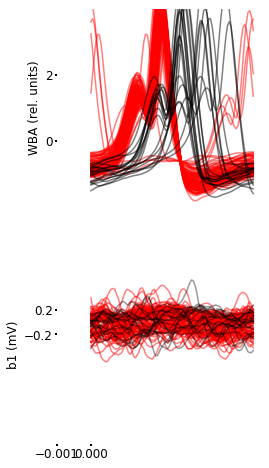

In [41]:
#### Maybe delete this


crimson = np.asarray(bl.segments[0].analogsignals[12])

indices = np.arange(len(crimson))

crimson_time= zip(indices, times, crimson)

def crimson_selection(threshold, data):
    sortedData = sorted(data, key=lambda x: x[2])
    finalList = filter(lambda x: x[2] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_high = crimson_selection(2.0, crimson_time)



crimson_inds_1= zip(indices, crimson)

def crimson_selection_1(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] > threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_high_1 = crimson_selection_1(2.0, crimson_inds_1)

####a
###Just take wave finder at those times!


def crimson_selection_none(threshold, data):
    sortedData = sorted(data, key=lambda x: x[1])
    finalList = filter(lambda x: x[1] < threshold, sortedData)
    return finalList if len(finalList) > 2 else 'No values found'

crimson_selection_zero_stim = crimson_selection_none(0.1, crimson_inds_1)

print(crimson_selection_high_1[0])

# detrend hütchens signal
hutch_det = hutch - np.mean(hutch)

#hutch_seg = hutch[1260000:1263000]
#musc_seg = musc[1260000:1263000]

hutch_seg = hutch[crimson_selection_high_1[0][0]+10:crimson_selection_high_1[0][0]+10000]
musc_seg = musc[crimson_selection_high_1[0][0]+10:crimson_selection_high_1[0][0]+10000]

deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]+10:crimson_selection_high_1[0][0]+10000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]

plt.figure(2)
plt.rc('font', size=12)
plt.rc('axes',linewidth=.5)
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['axes.linewidth'] = 2

fs_axon = 1.0/20000.0
t= np.linspace(0,len(hut_waveforms[0])/(1/fs_axon),len(hut_waveforms[0]))

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('w')

ax = fig.add_subplot(222)

for i in range(len(hut_waveforms)):
    ax.plot(t, hut_waveforms[i], 'r', alpha = 0.5)


ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

    
ax2 = fig.add_subplot(224)
for i in range(len(musc_wave)):
    ax2.plot(t, musc_wave[i], 'r', alpha = 0.5)


ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([])
ax2.set_xticks([])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')


#hutch_seg = hutch[1010000:1013000]
#musc_seg = musc[1010000:1013000]

hutch_seg = hutch[crimson_selection_high_1[0][0]-2000:crimson_selection_high_1[0][0]-20]
musc_seg = musc[crimson_selection_high_1[0][0]-2000:crimson_selection_high_1[0][0]-20]



deltas = np.diff(np.array(-1*hutch_det[crimson_selection_high_1[0][0]-4000:crimson_selection_high_1[0][0]-2000]>thresh,dtype = 'float'))
starts = np.argwhere(deltas>0.5)
stops = np.argwhere(deltas<-0.5)
if starts[0] > stops[0]:
    stops = stops[1:]
if stops[-1] < starts[-1]:
    starts = starts[:-1]
  
#find the peak changes in the thresholded signal, and find the associated waveform   
hut_intervals = np.hstack((starts,stops))
huttimes = [np.argmax(hutch_seg[sta:stp])+sta for sta,stp in hut_intervals][2:-2]
hut_waveforms = [hutch_seg[pk-52:pk+44] for pk in huttimes]
musc_wave = [musc_seg[pk-52:pk+44] for pk in huttimes]



ax = fig.add_subplot(222)

for i in range(len(hut_waveforms)):
    ax.plot(t, hut_waveforms[i], 'k', alpha = 0.5)

ax.set_ylabel('WBA (rel. units)')
ax.spines['left'].set_bounds(0, 2)
ax.set_ylim((-2, 4))
ax.set_xlim((-0.001, .005))
ax.set_yticks([0, 2])
ax.set_xticks([])
ax.tick_params(axis='both', which='major', pad=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

    
ax2 = fig.add_subplot(224)
for i in range(len(musc_wave)):
    ax2.plot(t, musc_wave[i], 'k', alpha = 0.4) #0.5

ax2.set_ylabel('b1 (mV)')
ax2.spines['left'].set_bounds(-0.2, 0.2)
ax2.set_ylim((-2, 1.25))
ax2.set_xlim((-0.001, .005))
ax2.set_yticks([-.2, .2])
ax2.spines['bottom'].set_bounds(-0.001, 0)
ax2.set_xticks([-0.001, 0])
ax2.tick_params(axis='both', which='major', pad=2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')


plt.savefig('hutch_n_spike.pdf')
plt().savefig
#gcf

**** switch here to make the fixed time on the chrimson time scale and then
upsample in the lower frequency area

In [ ]:
#***duplicate older version

#df_freq_upon_signal = pd.DataFrame()

#for i in range(len(crimson_on)):
#    on_signal = crimson_on[i]
#    off_signal = crimson_off[i]
#    f = b2_frequencies[on_signal-5000: off_signal+1000]
#    df_freq_upon_signal[i]=f

In [314]:
crimson_off[0] + 1000 - crimson_on[0] + 2500 

23499

In [207]:
#df_freq_upon_signal_2 = pd.DataFrame()
df_freq_upon_signal_3 = pd.DataFrame()

for i in range(len(crimson_on)-1):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
    if i != 0:
        if i !=len(crimson_on): 
            next_off_signal = crimson_off[i+1]
            next_on_signal = crimson_on[i+1]
            prior_off_signal = crimson_off[i-1]
            alt_f = b2_frequencies[prior_off_signal: next_on_signal]
        
            f3 = signal.resample(alt_f, 10000)
            xnew3 = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)
            df_freq_upon_signal_3[i]=f3
        
        
    #f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    #f2 = signal.resample(f, 500000)
    #xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    #x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    #df_freq_upon_signal_2[i]=f2

d={}
for x in range(1,10):
        d["crimson{0}".format(i)]="Hello"

In [ ]:
CHANGE FLY NUM

In [208]:
#df_freq_upon_signal_2 = pd.DataFrame()
df_freq_upon_signal_4 = pd.DataFrame()
d={} 

for i in range(len(crimson_on)-1):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
    if i != 0:
        if i !=len(crimson_on): 
            next_off_signal = crimson_off[i+1]
            next_on_signal = crimson_on[i+1]
            prior_off_signal = crimson_off[i-1]
            alt_f = b2_frequencies[prior_off_signal: next_on_signal]
        
            f3 = signal.resample(alt_f, 10000)
            xnew3 = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)
            df_freq_upon_signal_4[i]=f3
            resampled_crim = signal.resample(crimson[prior_off_signal: next_on_signal],10000)
            resampled_times = signal.resample(times[prior_off_signal: next_on_signal],10000)
            d["fly14_b2_df{0}".format(i)]=f3
            d["fly14_crimson{0}".format(i)]=resampled_crim
            d["fly14_times{0}".format(i)]= resampled_times
        
    #f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    #f2 = signal.resample(f, 500000)
    #xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    #x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    #df_freq_upon_signal_2[i]=f2

In [329]:
freq_hat_upsampled = signal.resample(freq_hat, len(freq_hat)*50)


#df_freq_upon_signal_2 = pd.DataFrame()
df_freq_upon_signal_4 = pd.DataFrame()
d={} 

for i in range(len(crimson_on)-1):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
    if i != 0:
        if i !=len(crimson_on): 
            next_off_signal = crimson_off[i+1]
            next_on_signal = crimson_on[i+1]
            prior_off_signal = crimson_off[i-1]
            alt_f = freq_hat_upsampled[prior_off_signal: next_on_signal]
        
            f3 = signal.resample(alt_f, 10000)
            xnew3 = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)
            df_freq_upon_signal_4[i]=f3
            resampled_crim = signal.resample(crimson[prior_off_signal: next_on_signal],10000)
            resampled_times = signal.resample(times[prior_off_signal: next_on_signal],10000)
            d["fly01_i1_df{0}".format(i)]=f3
            d["fly01_crimson{0}".format(i)]=resampled_crim
            d["fly01_times{0}".format(i)]= resampled_times
        
    #f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    #f2 = signal.resample(f, 500000)
    #xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    #x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    #df_freq_upon_signal_2[i]=f2

In [330]:
d

{'fly01_crimson1': array([0.09318698, 0.00165597, 0.00229518, ..., 0.00159645, 0.00236956,
        0.00176428]),
 'fly01_crimson10': array([0.09323625, 0.00185935, 0.00234188, ..., 0.00159888, 0.0022359 ,
        0.00163476]),
 'fly01_crimson2': array([0.23005424, 0.0013128 , 0.00258421, ..., 0.00131262, 0.00256311,
        0.00126309]),
 'fly01_crimson3': array([0.45664653, 0.00187746, 0.00221648, ..., 0.0017144 , 0.00213627,
        0.00179554]),
 'fly01_crimson4': array([0.09314572, 0.0015979 , 0.00224475, ..., 0.001599  , 0.00238951,
        0.00172222]),
 'fly01_crimson5': array([0.22976161, 0.0013729 , 0.00260307, ..., 0.00127796, 0.00254164,
        0.00130965]),
 'fly01_crimson6': array([0.45671151, 0.00218489, 0.00251158, ..., 0.00177509, 0.00225317,
        0.00184065]),
 'fly01_crimson7': array([0.0930987 , 0.0018412 , 0.00234277, ..., 0.00164479, 0.00218338,
        0.00164786]),
 'fly01_crimson8': array([0.22858898, 0.00261138, 0.00144962, ..., 0.00262581, 0.00127351,
    

In [331]:
resampled_df = pd.DataFrame(d)
resampled_df.head()

,fly01_crimson1,fly01_crimson10,fly01_crimson2,fly01_crimson3,fly01_crimson4,fly01_crimson5,fly01_crimson6,fly01_crimson7,fly01_crimson8,fly01_crimson9,...,fly01_times1,fly01_times10,fly01_times2,fly01_times3,fly01_times4,fly01_times5,fly01_times6,fly01_times7,fly01_times8,fly01_times9
0,0.093187,0.093236,0.230054,0.456647,0.093146,0.229762,0.456712,0.093099,0.228589,0.456365,...,8.714081,62.715815,14.714034,20.714038,26.713942,32.713996,38.713900,44.713879,50.714882,56.714886
1,0.001656,0.001859,0.001313,0.001877,0.001598,0.001373,0.002185,0.001841,0.002611,0.002206,...,2.482614,56.484408,8.482627,14.482572,20.482535,26.482648,32.482551,38.482442,44.482267,50.482270
2,0.002295,0.002342,0.002584,0.002216,0.002245,0.002603,0.002512,0.002343,0.001450,0.001865,...,3.999712,58.001491,9.999711,15.999669,21.999618,27.999717,33.999621,39.999532,45.999634,51.999638
3,0.001697,0.001730,0.001315,0.001828,0.001807,0.001351,0.001974,0.001573,0.002613,0.002139,...,3.103926,57.105714,9.103934,15.103884,21.103841,27.103948,33.103852,39.103751,45.103689,51.103693
4,0.002310,0.002374,0.002661,0.002294,0.002422,0.002651,0.002215,0.002324,0.001556,0.002069,...,3.743242,57.745024,9.743244,15.743200,21.743151,27.743253,33.743156,39.743064,45.743119,51.743123


In [332]:
from scipy import stats

In [333]:
fly_14_b2_mean_freq_change = df_freq_upon_signal_4.mean(axis=1)
fly_14_b2_freq_error = stats.sem(df_freq_upon_signal_4,axis = 1)

In [334]:
#fly_01_b2_mean_freq_change.iloc[0]
fly_14_b2_mean_freq_change_series = fly_14_b2_mean_freq_change.T
#type(_)
type(fly_14_b2_mean_freq_change_series)

pandas.core.series.Series

In [597]:
#fly_01_b2_mean_freq_change_series

In [335]:
type(fly_14_b2_mean_freq_change)
type(fly_14_b2_freq_error)
#fly_01_b2_freq_error
#fly_01_b2_freq_error = pd.Series(fly_01_b2_freq_error)
#shape(fly_01_b2_freq_error)
#fly_01_b2_mean_freq_change = df.values(fly_01_b2_mean_freq_change)

numpy.ndarray

In [570]:
#fly_01_b2_mean_freq_change.head()
#fly_01_b2_freq_error = pd.DataFrame(fly_01_b2_freq_error)

In [336]:
d["fly_01_i1_mean_freq_change_series"]=fly_14_b2_mean_freq_change_series
d["fly_01_i1_freq_error"]=fly_14_b2_freq_error

In [337]:
resampled_df = pd.DataFrame(d)
resampled_df.head()

,fly01_crimson1,fly01_crimson10,fly01_crimson2,fly01_crimson3,fly01_crimson4,fly01_crimson5,fly01_crimson6,fly01_crimson7,fly01_crimson8,fly01_crimson9,...,fly01_times2,fly01_times3,fly01_times4,fly01_times5,fly01_times6,fly01_times7,fly01_times8,fly01_times9,fly_01_i1_freq_error,fly_01_i1_mean_freq_change_series
0,0.093187,0.093236,0.230054,0.456647,0.093146,0.229762,0.456712,0.093099,0.228589,0.456365,...,14.714034,20.714038,26.713942,32.713996,38.713900,44.713879,50.714882,56.714886,0.033413,0.035681
1,0.001656,0.001859,0.001313,0.001877,0.001598,0.001373,0.002185,0.001841,0.002611,0.002206,...,8.482627,14.482572,20.482535,26.482648,32.482551,38.482442,44.482267,50.482270,0.073162,0.072531
2,0.002295,0.002342,0.002584,0.002216,0.002245,0.002603,0.002512,0.002343,0.001450,0.001865,...,9.999711,15.999669,21.999618,27.999717,33.999621,39.999532,45.999634,51.999638,0.068528,0.068103
3,0.001697,0.001730,0.001315,0.001828,0.001807,0.001351,0.001974,0.001573,0.002613,0.002139,...,9.103934,15.103884,21.103841,27.103948,33.103852,39.103751,45.103689,51.103693,0.077833,0.075690
4,0.002310,0.002374,0.002661,0.002294,0.002422,0.002651,0.002215,0.002324,0.001556,0.002069,...,9.743244,15.743200,21.743151,27.743253,33.743156,39.743064,45.743119,51.743123,0.078241,0.075315


In [338]:
resampled_df.to_csv('/home/alysha/analysis_files/S104/s104_i1_df_fly_01.csv', index=False)



In [364]:
df_freq_upon_signal_2 = pd.DataFrame()


for i in range(len(crimson_on)):
    on_signal = crimson_on[i] - 2500
    off_signal = crimson_off[i] + 1000
    
    #prior_off_signal = crimson_off[i-1]
         
        
    f = b2_frequencies[on_signal: off_signal]
    #f3 = signal.resample(alt_f, 1000000)
    #xnew3 = np.linspace(prior_off_signal, prior_off_signal, 1000000, endpoint=False)
    #x = np.linspace (prior_off_signal,next_on_signal, next_on_signal-prior_off_signal, endpoint = False)
    
    
    f2 = signal.resample(f, 500000)
    xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)
    x = np.linspace (on_signal, off_signal, off_signal-on_signal, endpoint = False)
    df_freq_upon_signal_2[i]=f2

In [310]:
x = np.arange(on_signal, off_signal)
xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)

import matplotlib.pyplot as plt
plt.plot(x, f, 'go-', xnew, f2, '.-', on_signal, f[12], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

TypeError: 'int' object has no attribute '__getitem__'

ValueError: x and y must have same first dimension, but have shapes (23497,) and (23500,)

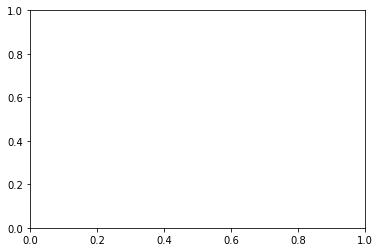

In [268]:
x = np.arange(on_signal, off_signal)
xnew = np.linspace(on_signal, off_signal, 500000, endpoint=False)

import matplotlib.pyplot as plt
plt.plot(x, f, 'go-', xnew, f2, '.-', off_signal, f[12], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

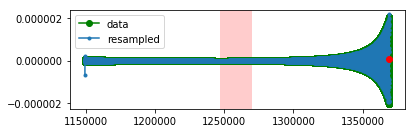

In [339]:
fig =plt.figure(18)

x = np.arange(prior_off_signal, next_on_signal)
xnew = np.linspace(prior_off_signal, next_on_signal, 10000, endpoint=False)

ax2 = fig.add_subplot(212)

import matplotlib.pyplot as plt
plt.plot(x, alt_f, 'go-', xnew, f3, '.-', next_on_signal, alt_f[11], 'ro')
ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
#ax2.axvspan(prior_on_signal, prior_off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [220]:
df_freq_upon_signal_3.head()

,1,2,3,4,5,6,7,8,9,10
0,17.432347,28.803801,35.626269,398.507734,29.526701,673.725775,685.663503,25.087620,24.822572,8.860274
1,8.324689,40.315052,70.037642,803.157656,17.795272,1500.817394,-120.053249,52.248144,41.481808,17.312089
2,10.634800,37.275289,60.538460,707.785377,20.355973,1077.252968,76.162217,45.376667,37.550770,15.414457
3,10.400880,39.182491,66.768416,762.513370,18.999360,287.750777,-40.046429,49.585503,39.811077,16.451911
4,22.785631,37.767508,61.903803,724.800318,19.852689,254.005855,42.733638,46.488755,38.248803,15.773748


In [175]:
df_freq_upon_signal_2.head()

NameError: name 'df_freq_upon_signal_2' is not defined

In [62]:
outliers =[]


'''
for i in df_freq_upon_signal:
    #on_signal = crimson_on[i]
    for j in range(len(df_freq_upon_signal[i])):
        if df_freq_upon_signal[i][j]>= 150:
            outliers.append(i)
'''

In [67]:
#print(outliers)

#new_df = df_freq_upon_signal.drop(17, axis=1)#.head()

In [342]:
#new_df = df_freq_upon_signal_2
new_df = df_freq_upon_signal_4

In [ ]:
#fig =plt.figure(18)

#x = np.arange(prior_off_signal, next_on_signal)
#xnew = np.linspace(prior_off_signal, next_on_signal, 1000000, endpoint=False)

#ax2 = fig.add_subplot(212)

#import matplotlib.pyplot as plt
#plt.plot(x, alt_f, 'go-', xnew, f3, '.-', next_on_signal, alt_f[11], 'ro')
#ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
##ax2.axvspan(prior_on_signal, prior_off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
#plt.legend(['data', 'resampled'], loc='best')
#plt.show()

'freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'

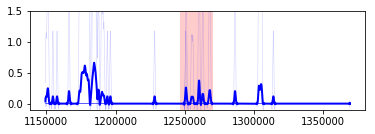

In [345]:
fig =plt.figure(15)

ax1 = plt.subplot(211)

for i in new_df:
    ax1.plot(xnew, new_df[i], 'b', linewidth =0.5, alpha = 0.2)
    
    
ax1.set_ylim((-.1,1.5))
#ax1.set_ylimit(-0.1, 100)
#ax1.set_xlim((1200000,1300000))


mean_freq_change = new_df.mean(axis=1)
ax1.plot(xnew, mean_freq_change, 'b', linewidth =2.0)

ax1.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)

'''
ax1.plot(times, crimson, 'r', linewidth =1.0)

ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylim(0, 20)
#ax2.set_xlim(20, 80)
#savitzky_golay
'''
'''freq_hat = savgol_filter(b2_frequencies, 7, 5) # window size 51, polynomial order 3'''
#freq_hat= b2_frequencies 
#ax2.plot(times_k, b2_frequencies,'k', linewidth = 0.75)
        
#for i in range(len(crimson_on)):
#    ax1.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)
#    #ax2.axvspan(times[crimson_on[i]], times[crimson_off[i]], facecolor = 'r', edgecolor = 'none', alpha = 0.3)

In [346]:
from scipy import stats

In [347]:
mean_freq_change = new_df.mean(axis=1)
freq_error = stats.sem(new_df,axis = 1)

Text(0.5,0,u'Time (s)')

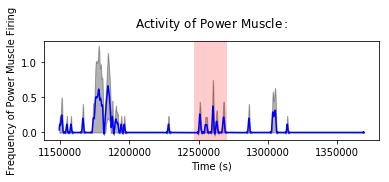

In [348]:
fig =plt.figure(16)


#wbf_means = wbf_means[0:len(wbf_means):10]
#wbf_error = stats.sem(all_wbf,axis = 0)
#wbf_error = wbf_error[0:len(wbf_error):10]

ax2 = fig.add_subplot(212)

#ax2.set_ylim((-30,150))
#ax1.set_ylimit(-0.1, 100)
#ax2.set_xlim((1220000,1300000))
#ax2.set_xlim((1340000,1400000))

#ax2.axvspan(0.25, .75, facecolor = 'r', edgecolor = 'none', alpha = 0.3)
ax2.axvspan(on_signal, off_signal, facecolor = 'r', edgecolor = 'none', alpha = 0.2)
ax2.plot(xnew,mean_freq_change, 'b')
ax2.fill_between(xnew,mean_freq_change+freq_error, mean_freq_change-freq_error,color='k', alpha = 0.3, edgecolor = 'none')

ax2.set_title(r'$\mathrm{Activity\ of\ Power \ Muscle:}$', size=12, horizontalalignment='center',  y=1.08)#   \ \mu=100,\ \sigma=15$', size=12, horizontalalignment='center',  y=1.08) #verticalalignment='top')
ax2.set_ylabel('Frequency of Power Muscle Firing', size=10)
plt.xlabel('Time (s)', size=10) # $\phi$', size=10)
#ax2.title('B2 spike frequency')

In [ ]:
### Then plot this over time
### Update on git -- new analysis file for each genotype
### Develop a pattern of dataframe organization
### blue card 
### bills
### analysis
### tutor
### cv website
### laudry 


In [349]:
#altair and bokeh plotting

new_df.to_csv('s81_i1_01_df.csv', index=False)